# Preámbulo

Como es de rigor, hay que ejecutar la siguiente celda antes que nada.

In [1]:
#
# paquete con utilidades y código del libro
# de Andreas Müller & Sarah Guido
#
!pip install --quiet mglearn
import mglearn

import matplotlib as mpl 

mpl.rcParams['figure.figsize'] = [6.0, 4.0]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 150

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'


     |████████████████████████████████| 540 kB 6.9 MB/s 


# Selección y validación de modelos

## Sobreajuste de hiperparámetros y validación 

Hasta ahora, la metodología que usamos para elegir modelos fue la siguiente:

*   Dividimos aleatoriamente los datos de entrenamiento en dos subconjuntos: _entrenamiento_ (_train_) y _evaluación_ (_test_)
*   Ajustamos los parámetros de un modelo a los datos; repetimos lo anterior para un conjunto de valores de _hiperparámetros_ que controlan la complejidad del modelo. Ejemplos de estos son:
    *   orden de polinomio
    *   constante de penalización $\lambda$, $C$, etc
* Nos quedamos con el modelo/hiperparámetro tal que el desempeño sobre el conjunto de _test_ era menor

Si repasamos el procedimiento anterior, veremos que hay algo fijo en él, y es precisamente la división particular que se usó de los datos disponibles en _entrenamiento_ y _test_. 

El siguiente experimento muestra que, efectivamente, esto implica un sobreajuste no despreciable.

El experimento consiste en los siguientes pasos:

*   Como siempre, partimos el conjunto de datos disponible en dos: entrenamiento y test. Podemos pensar que los datos de test nunca fueron parte de nuestros datos disponibles, sino que son datos que se nos dieron para hacer una evaluación final de modelo. Así es como funcionan, por ejemplo, las competencias online de Machine Learning.
*   Ahora, repetimos $R$ veces:
    *    Volvemos a dividir los datos de entrenamiento restantes de manera aleatoria, esta vez en uno de entrenamiento y otro llamado de _validación_
    *    Repetimos todo el procedimiento original sobre estos dos conjuntos para hallar el mejor modelo y sus hiperparámetros; en este caso vamos a considerar polinomios, donde el hiperparámetro es el orden del polinomio a ajustar
    *    Guardamos el mejor modelo obtenido con este método y lo aplicamos al conjunto de validación; esto nos da un score de validación
    *    Medimos el desempeño final de este modelo sobre el conjunto reservado para  test, _que no ha sido visto nunca hasta este momento_
 

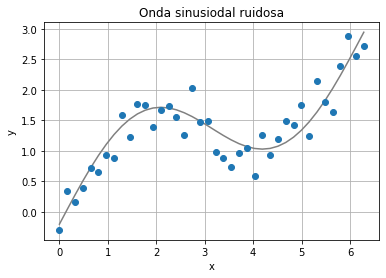

In [2]:
import numpy as np
import numpy.random as rng

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
#
# copiado del práctico 4:
# 
# f(x) = a*sen(wx) + b*x + c 
#
def onda_ruidosa(num_muestras,amplitud=1,frecuencia=1,fase=0,ruido=0,constante=0,deriva=0,semilla=44441111):
  '''
  genera muestras de una onda sinusoidal de amplitud, frecuencia y fase
  deseadas, con una cantidad de ruido específica
  '''
  rng.seed(semilla)
  X = np.ones((num_muestras,1))
  X = np.linspace(0,2*np.pi,num=num_muestras)
  y = amplitud*np.sin(frecuencia*X+fase) + deriva*X + constante + ruido*rng.randn(num_muestras)
  X = X.reshape(1,-1).T # detalle técnico oscuro y que no aporta nada
  return X,y

#
# generamos algunas muestras
# 
N = 40
X, ytilde = onda_ruidosa(num_muestras=N,ruido=0.0,deriva=0.5,constante=-0.2)
X, y      = onda_ruidosa(num_muestras=N,ruido=0.3,deriva=0.5,constante=-0.2)

plt.plot(X, ytilde, '-',color=(0.5,0.5,0.5,1.0))
plt.plot(X, y, 'o')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Onda sinusiodal ruidosa")
plt.grid(True)
plt.show()


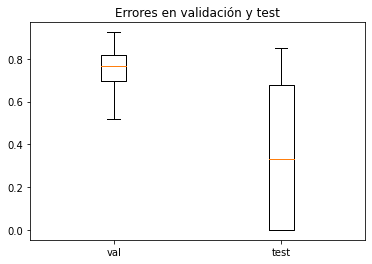

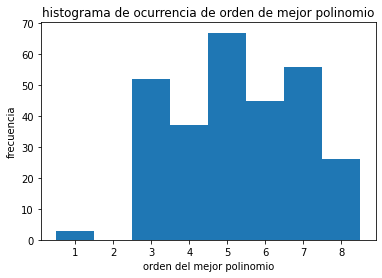

In [4]:
#
# separamos los datos en TRES
# 
# primero separamos datos en entrenamiento y test
#
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=10)
#
# repetimos
#
nrep = 300
score_val = list()
score_test = list()
best_order = list()
#
# subdividimos el de entrenamiento en entrenamiento y validación 
# usamos la misma función, solo que ahora le llamamos "val" a los "test"
#
# nos quedan 20 para entrenar, 10 para validar
#
best_score_val = list()
best_score_test = list()
best_order = list()
X_train_val = np.copy(X_train)
y_train_val = np.copy(y_train)
for j in range(nrep):
  X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val,random_state=42+j*3,test_size=10)  
  score_train = list()
  score_val = list()
  # probamos ordenes de 1 a 9 
  poly_order = np.arange(1,10) 
  for p in poly_order:
    preproc = PolynomialFeatures(degree=p, include_bias=False)
    preproc.fit(X_train)
    X_train_poly = preproc.transform(X_train)
    X_val_poly = preproc.transform(X_val)
    X_test_poly = preproc.transform(X_test)
    modelo = LinearRegression().fit(X_train_poly, y_train)
    score_val.append( modelo.score(X_val_poly,y_val) )
  # tomamos el mejor según el score de validación para esta repetición
  max_idx = np.argmax(score_val)
  best_order.append(poly_order[max_idx])
  best_score_val.append(score_val[max_idx])
  # evaluamos en test
  best_score_test.append( modelo.score(X_test_poly, y_test))

best_score_test_trim = [b if b > 0 else 0 for b in best_score_test]

plt.boxplot((best_score_val,best_score_test_trim),labels=('val','test'),showfliers=0)
plt.title('Errores en validación y test')
plt.show()

plt.hist(best_order,bins=np.arange(1,10)-0.5)
plt.xlabel('orden del mejor polinomio')
plt.ylabel('frecuencia')
plt.title('histograma de ocurrencia de orden de mejor polinomio')
plt.show()


## Preguntas

*spoiler alert*: no miren la siguiente sección antes de responder estas preguntas!

1.   Qué se observa en la primera figura de arriba?
1.   Qué se observa en la segunda figura?
1.   Qué conclusiones podemos sacar de ellas?



## Paréntesis -- números pseudo-aleatorios y semillas

Es importante recordar el detalle, aunque sea algo técnico, de que los números aleatorios en la mayoría de las simulaciones y aplicaciones computacionales no son realmente aleatorios sino _pseudo-aleatorios_. 

Estos números son generados secuencialmente de manera que _parezcan_ al azar, pero de hecho no lo son: el _generador_ de números pseudoaleatorios (random number generator, o RNG) genera una secuencia específica según una _semilla_ que se define antes de comenzar a generarlos. Para una semilla dada, la secuencia generada es siempre la misma.

La calidad del generador suele ser un factor determinante en la calidad de un sistema que depende de muestras al azar para obtener sus resultados. 

Lo segundo importante a recordar: es fundamental fijar la semilla de antemano para obtener resultados _reproducibles_! Si uno no la fija, suele usarse como semilla la hora actual, o algo que realmente no es repetible.




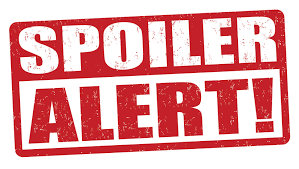

## Tres conjuntos

Espero que no hayan mirado esto antes de responder las preguntas anterires. Las respuestas (entre otras posibles) son las siguientes:

1.   El score en _test_ es significativamente menor que el obtenido en _validación_ con el polinomio de _mejor orden_ 
1.   El orden óptimo obtenido por validación varía enormemente según la subdivisión particular del conjunto de entrenamiento 
1.   Lo anterior da cuenta de un fenómeno de _overfitting_: la estimación del desempeño en _validación_ es muy optimista respecto a la real observeda en un conjunto de datos completanemte nuevo (el de _test_)
1.   Hay mucha _incertidumbre_, tanto en validación como en test, según la división particular elegida

El primer problema, el de la estimación optimista del desempeño, es algo que hay que tener en cuenta siempre al reportar resultados en Aprendizaje Automático. 

**Es fundamental reservar un conjunto de test para reportar los resultados finales de un sistema de aprendizaje automático**

En resumen, el procedimiento que veníamos aplicando hasta ahora se modifica de la siguiente manera:

*   Dividimos nuestro conjunto de datos total en dos: uno de _entrenamiento_ y otro de _test_. A diferencia de los ejercicios anteriores, _este_ conjunto de test no será utilizado para validación, sino que será reservado para el final.
*   El aprendizaje se realizará con los datos de _entrenamiento_ solamente. Cuando hay hiperparámetros, como en el caso anterior, volveremos a subdividir este conjunto en uno de _entrenamiento_ y otro de _validación.

## Validación cruzada

Tal como se describió anteriormente, el nuevo procedimiento se resume, en definitiva, en dividir el conjunto de datos disponible en _tres_ conjuntos: _entrenamiento_, _validación_ y _test_.

Este método, sin embargo, no resuelve el problema de la variabilidad de los resultados con respecto a la subdivisión particular que se realice entre _entrenamiento_ y _validación_.

Hay otro problema más técnico: cuando se dispone de pocos datos, reservar un porcentaje grande (por ejemplo, 30%) para validación puede dejarnos con una cantidad insuficiente para entrenar. 

Para tratar los dos problemas anteriores existe la _validación cruzada_. Esto consiste en dividir en conjunto de entrenamiento en $N$ subconjuntos y luego repetir el proceso de ajuste de hiperparámetros $N$ veces. En cada repetición, uno de los subconjuntos se reserva para validación, y los otros $N-1$ se usan para entrenamiento.

De la manera anterior, pordemos disponer de una buena cantidad de datos para entrenar, por ejemplo 80% o 90% (N=5 o N=10 respectivamente) y a la vez tener varias estimaciones del desempeño, lo que nos permite calcular márgenes de confianza además de un valor promedio.

Veamos cómo opera este método en el ejemplo que venimos viendo

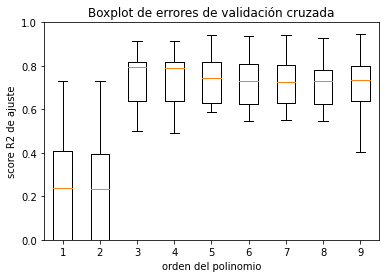


score en test: 0.7721132888437618


In [5]:
ntotal = 100
X, ytilde = onda_ruidosa(num_muestras=ntotal,ruido=0.0,deriva=0.5,constante=-0.2)
X, y      = onda_ruidosa(num_muestras=ntotal,ruido=0.3,deriva=0.5,constante=-0.2)

#
# separamos los datos en TRES
# 
# primero separamos datos en entrenamiento y test
#
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=42,test_size=30)
#
# repetimos
#
nsamples = len(y_train_val)
nrep = 300
score_val = list()
score_test = list()
best_order = list()
#
# subdividimos el de entrenamiento en 10 "folds" 
#
N=10

# nos quedan 20 para entrenar, 10 para validar
#
scores = list()
# probamos ordenes de 1 a 9 
poly_order = np.arange(1,10) 
for p in poly_order:
  # evaluamos en cada fold
  scores_fold = list()
  for n in range(N):
    
    X_train = np.delete(X_train_val,range(n,nsamples,N),axis=0)
    y_train = np.delete(y_train_val,range(n,nsamples,N))
    X_val   = X_train_val[n::N,:]
    y_val   = y_train_val[n::N]
    
    preproc = PolynomialFeatures(degree=p, include_bias=True)
    X_train_poly = preproc.fit(X_train).transform(X_train)
    X_val_poly = preproc.transform(X_val)
    X_train_poly = preproc.transform(X_train)
    modelo = LinearRegression().fit(X_train_poly, y_train)
    scores_fold.append( modelo.score(X_val_poly,y_val) )
  #
  # como son pocos scores (10), usamos un estimador robusto (mediana)
  # para calcular el score medio para un orden de polinomio dado
  #
  scores.append(scores_fold)

plt.boxplot(scores,labels=([str(i) for i in range(1,10)]),showfliers=0)
plt.title('Boxplot de errores de validación cruzada')
plt.xlabel('orden del polinomio')
plt.ylabel('score R2 de ajuste')
plt.ylim(0,1)
plt.show()

#
# finalmente, elegimos el mejor modelo como aquel que
# arrojó el mejor desempeño medio en validación cruzada
# que sería p=3
#
# ahora, si queremos, podemos reajustar el modelo a todos los 
# datos de entrenamiento disponibles
#
preproc = PolynomialFeatures(degree=3, include_bias=True)
X_train_val_poly = preproc.fit(X_train_val).transform(X_train_val)
modelo = LinearRegression().fit( X_train_val_poly, y_train_val)
#
# y evaluamos, ahora sí, recién ahora, en test!
# este valor podemos reportarlo con más seguridad 
#
X_test_poly = preproc.fit(X_test).transform(X_test)
print("\nscore en test:",modelo.score(X_test_poly,y_test))


## Confianza en el conjunto de test

El lector avispado puede preguntarse si no tenemos de nuevo el problema de incertidumbre en el conjunto de test. Está bien, podemos simular que nunca vimos lo datos de test, pero en los hechos los estamos muestreando de nuestro conjunto de datos total. Claramente, habrá variaciones según cómo hagamos la primera división.

Lo más sencillo en este caso, y bastante seguro en la práctica, es repetir la evaluación final $M$ veces, tomando distintos subconjuntos al azar del conjunto de _test_ en cada repetición, _con reposición_. Esto es conocido como _bootstrap_, y es una técnica bien estudiada de estadística no paramétrica.

Hagámoslo sobre nuestro conjunto de datos para tener una idea de la confiabilidad del score final obtenido 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


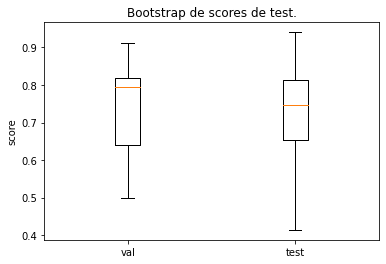

In [6]:
X_test_poly = preproc.fit(X_test).transform(X_test)
ntest = len(y_test)
scores_bootstrap = list()
for B in range(1000):
  idx = rng.randint(0,ntest,ntest//2) # muestras de 50% con reposición
  X_bootstrap = X_test_poly[idx,:]
  y_bootstrap = y_test[idx]
  scores_bootstrap.append(modelo.score(X_bootstrap,y_bootstrap))
plt.boxplot((scores[2],scores_bootstrap),labels=('val','test'),showfliers=False)
plt.title('Bootstrap de scores de test.')
plt.ylabel('score')
plt.show()

### Preguntas

Cómo se comparan el resultado final en test y el de validación en este caso?
Puntualmente:
*   Son más o menos parecidos que los que se obtuvo sin validación cruzada?


## Selección de modelos basada en criterios de parsimonia

En muchas ocasiones no es posible dividir el conjunto de datos en entrenamiento, validación y test. De hecho, en muchos casos, no es posible dividir el conjunto de datos de ninguna manera.

Lo anterior ocurre, por ejemplo, en sistemas que se adaptan _online_, como robots o sistemas de recomendación, y otros tantos. Pero también sucede cuando el costo de entrenamiento es _tal_ que no es práctico repetir el entrenamiento N veces. Por ejemplo, una red neuronal profunda de miles de millones de parámetros puede demorar semanas en entrenarse. Nadie querría transformar 5 semanas en 50 (x10) lo que equivale a un año.

Finalmente, a veces se dispone de muy pocos datos. Tan pocos que no es posible siquiera dividir el conjunto y tener estimaciones razonables de los parámetros.


Esto puede parecer forzado en una época en donde parece que hay  grandes volúmenes de datos por todos lados. Sin embargo, en muchos ámbitos de la práctica científica, conseguir muestras es un proceso caro y lento, y a veces no es posible tener más de una o dos decenas de muestras.

En esas situaciones, y otras tantas, los métodos de selección basados en datos no son prácticos. En su lugar, existen criterios que buscan caracterizar de manera implícita el balance entre ajuste a datos y complejidad de modelo. Los más conocidos son tres:

*   Akaike's Information Criterion (AIC) (Akaike, 1974) y su versión actualizada, AIC2
*   Bayesian Information Criterion (BIC) (Schwartz, 1978)
*   Minimum Description Length (MDL) (Rissanen, 1982)

Los tres métodos son bien distintos en su concepción. El primero, AIC, es una aproximación asintótica al error de _leave one out_ (validación cruzada dejando de a una sóla muestra para validación cada vez); el segundo también trabaja sobre una aproximación asintótica, pero de la probabilidad a posteriori de los datos; el tercero utiliza conceptos de Teoría de la Información y Complejidad de Kolmogorov-Chaitin-Solomonoff. Más allá de los tecnicismos involucrados (llevaría un curso aparte), al menos los dos primeros pueden ser aplicados de manera muy sencilla, si bien todos se limitan a modelos probabilísticos. (Ya MDL requiere un poco más de conocimiento técnico, pero es tambien es el que hace menos aproximaciones y suposiciones para llegar a su resultado.)

Concretamente, si podemos expresar el ajuste a datos como una verosimilitud, tenemos: 

$$AIC = -\log P(\mathbf{x},\mathbf{y}|\theta) + \mathrm{dim}(\theta)$$

donde $\theta$ es el estimador de máxima verosimilitud de los parámetros del modelo y $\mathrm{dim}(\theta)$ es la dimensión del vector de parámetros (por ejemplo, en un polinomio de orden $p$, $\mathrm{dim}(\theta)=p+1$). Para BIC  tenemos

$$BIC = -\log P(\mathbf{x},\mathbf{y}|\theta) + \frac{\mathrm{dim}(\theta)}{2}\log n$$

donde $n$ es la cantidad de datos evaluados. 

## Puesta en práctica

Veamos cómo funcionan estos dos métodos con el problema en cuestión.

No vamos a subdividir el conjunto de entrenamiento. Vamos a mantener, sí, el conjunto de _test_ aparte para hacer la evaluación final. 

Lo que sí tenemos que hacer es expresar nuestro ajuste a datos como una probabilidad. Para esto no podemos usar el R2. Lo que vamos a hacer es asumir que nuestras muestras son la suma de un polinomio (el polinomio ajustado) más un error Gaussiano de media nula y varianza desconocida. 

$$ P(x_j,y_j|\mathbf{a},\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(f(x_j)-y_j)^2}{2\sigma^2}}$$


Luego de tomar el logaritmo de la distribución exponencial, nos queda lo siguiente:

$$ -\log P(x_j,y_j|\mathbf{a},\sigma^2) = \frac{1}{2}\log 2\pi\sigma^2 + \frac{1}{2\sigma^2}(\sum_ia_ix_{ji}-y_j)^2_2$$

El estimador de máxima verosimilitud es 
$$\hat{\sigma}^2=\frac{1}{n}\sum_{j=1}^{n} (f(x_j) - y_j)^2.$$

Sustituyendo esa expresión en la anterior, nos queda:

$$ -\log P(x_j,y_j|\mathbf{a},\theta) = \frac{1}{2}\log \left[2\pi\frac{1}{n}\sum_{j=1}^{n} (f(x_j) - y_j)^2\right] + \frac{n}{2}.$$

Tenemos $p+2$ parámetros: 1+p del polinomio de orden p, y otro por $\sigma^2$.  El criterio AIC queda entonces:

$$ AIC = \frac{1}{2}\log \left[2\pi\frac{1}{n}\sum_{j=1}^{n} (f(x_j) - y_j)^2\right] + \frac{n}{2} + (p+2).$$

El BIC es casi igual:

$$ BIC = \frac{1}{2}\log \left[2\pi\frac{1}{n}\sum_{j=1}^{n} (f(x_j) - y_j)^2\right] + \frac{n}{2} + \frac{p+2}{2}\log n.$$


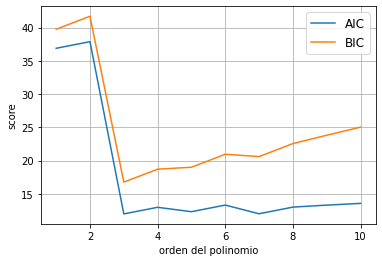

In [7]:
ntotal = 60
X, ytilde = onda_ruidosa(num_muestras=ntotal,ruido=0.0,deriva=0.5,constante=-0.2)
X, y      = onda_ruidosa(num_muestras=ntotal,ruido=0.3,deriva=0.5,constante=-0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=10)

def AIC(y,y_pred,ndims):
  n = len(y)
  MSE = np.mean((y-y_pred)**2)
  return 0.5*(n*np.log(2*np.pi*MSE) + n + 2*ndims)

def BIC(y,y_pred,ndims):
  n = len(y)
  MSE = np.mean((y-y_pred)**2)
  return 0.5*(n*np.log(2*np.pi*MSE) + n + ndims*np.log(n))

scores_aic = list()
scores_bic = list()
# probamos ordenes de 1 a 9 
poly_order = np.arange(1,11) 
for p in poly_order:
  preproc = PolynomialFeatures(degree=p, include_bias=True)
  X_train_poly = preproc.fit(X_train).transform(X_train)
  modelo = LinearRegression().fit(X_train_poly, y_train)
  y_pred = modelo.predict(X_train_poly)
  scores_aic.append( AIC(y_pred,y_train,p+2 ) )
  scores_bic.append( BIC(y_pred,y_train,p+2 ) )
plt.figure()
plt.plot(poly_order,scores_aic,label='AIC')
plt.plot(poly_order,scores_bic,label='BIC')
plt.grid(True)
plt.legend()
plt.xlabel('orden del polinomio')
plt.ylabel('score')
plt.show()


### Preguntas

*   Cuál es el mejor orden obtenido por AIC?
*   Cuál es el mejor orden obtenido con BIC?
(   Cuál es el más restrictivo de los dos criterios?